In [12]:
from src.datasets import NoisySpeechDataset
from src.utils import checkpoint
from src.utils.notebook import Sampler, visualize_audio 

In [13]:
DOWNLOAD = '/home/matt/Downloads/indicator.resampled.wav'

In [14]:
CHECKPOINT = 'wave-u-net-new-baseline-1573165774.full.ckpt'  # GAN baseline 6 epochs

In [15]:
dataset = NoisySpeechDataset(train=False)
net = checkpoint.load(CHECKPOINT, use_cuda=False)
net = net.eval()
sampler = Sampler(net, dataset)

100%|██████████| 824/824 [00:00<00:00, 11159.13it/s]

Loading validation dataset into memory.
Loading clean data...
Loading noisy data...


Done loading dataset into memory.


In [16]:
# noisy_arr, pred_clean, pred_noise = get_results_from_file(DOWNLOAD, start=0)#2**18)

In [17]:
noisy_arr, clean_arr, pred_clean, pred_noise, true_noise = sampler.get_results(1)

Predicted clean signal


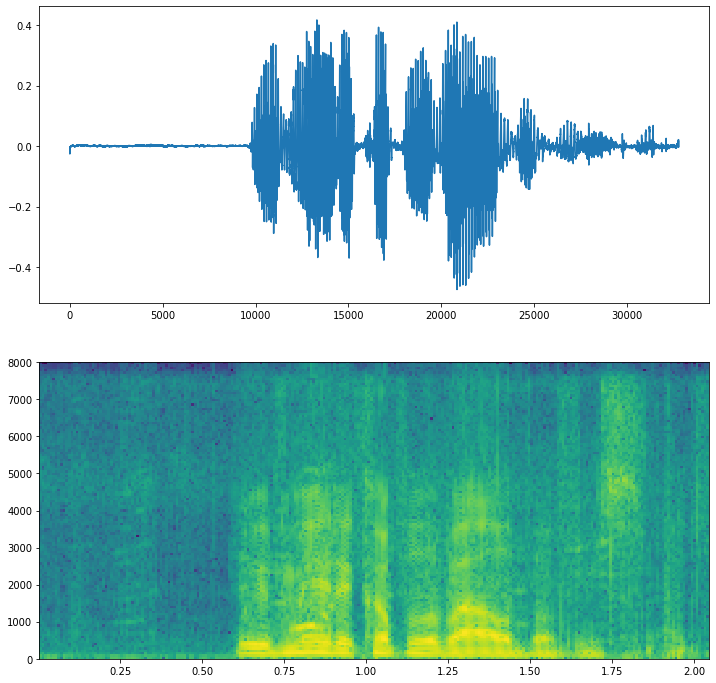

In [18]:
visualize_audio(pred_clean, 'Predicted clean signal')

Clean signal


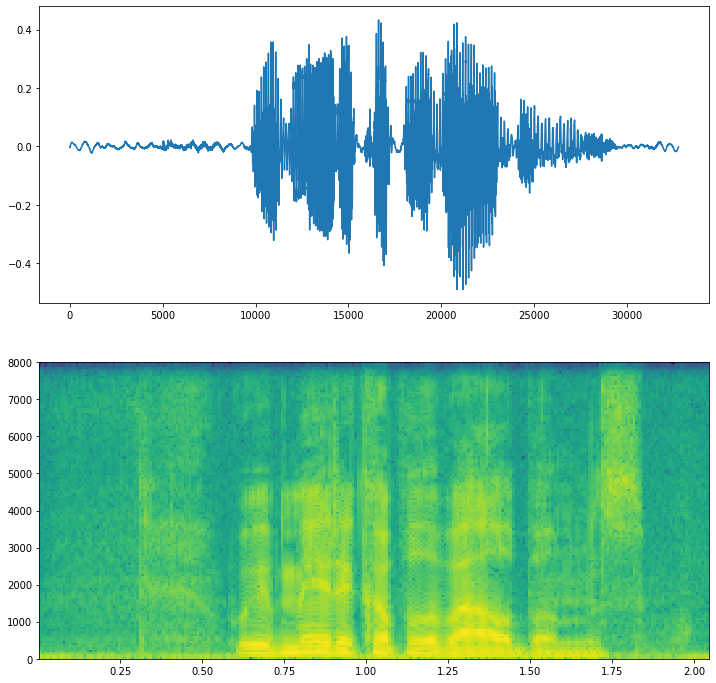

In [19]:
visualize_audio(clean_arr, 'Clean signal')

Noisy signal


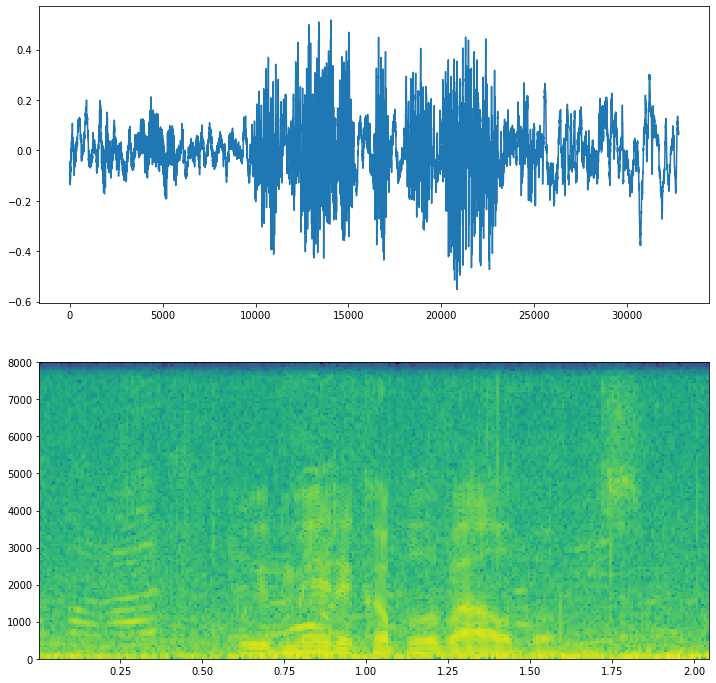

In [20]:
visualize_audio(noisy_arr, 'Noisy signal')

Predicted noise


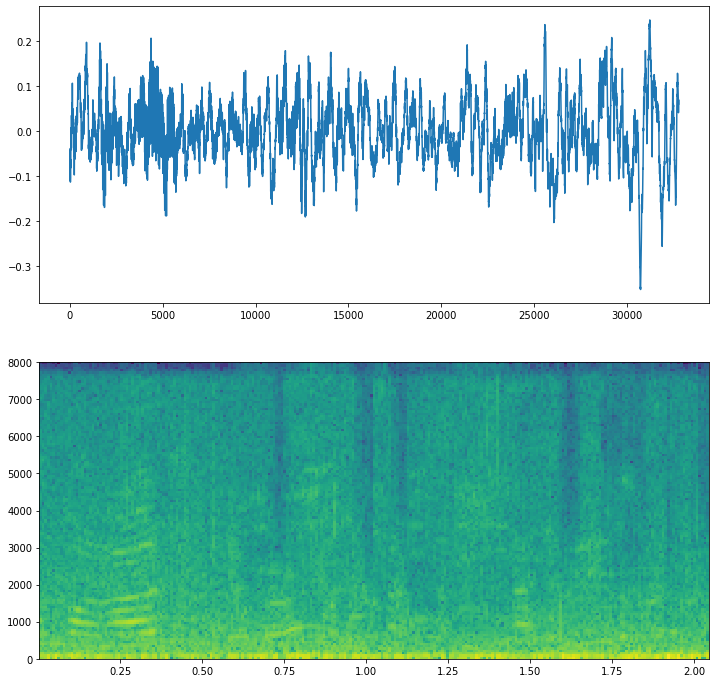

In [21]:
visualize_audio(pred_noise, 'Predicted noise')

True noise signal


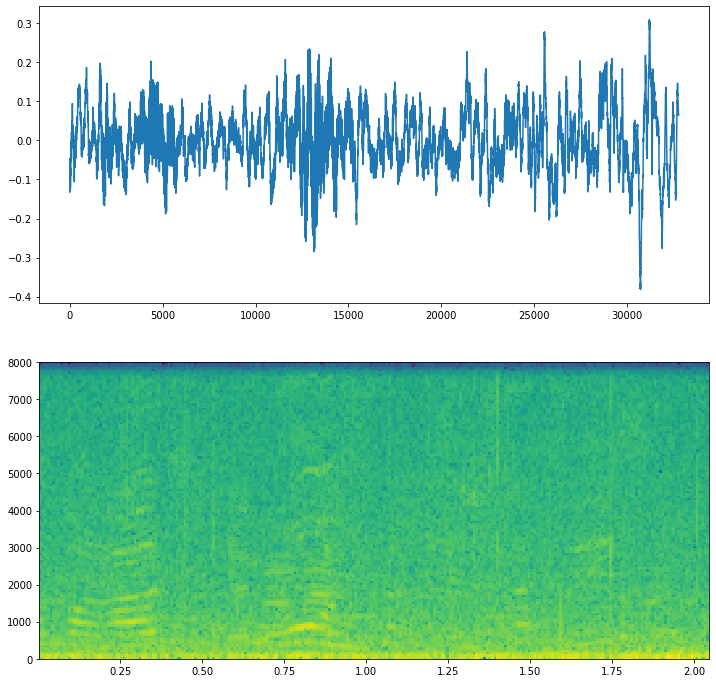

In [22]:
visualize_audio(true_noise, 'True noise signal')